# ITIS6220: Data Privacy
## Homework 3

In [29]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

In [30]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Question 1 (5 points)

Implement the `dp_occupation_histogram` function below. It should return a differentially private histogram over the `Occupation` column in the `adult` dataset. Your function should have a total privacy cost of `epsilon` and should use parallel composition.

In [33]:
def dp_occupation_histogram(epsilon):
   # Compute the true histogram
   hist = adult['Occupation'].value_counts()
   # Compute the sensitivity of the query
   sensitivity = 1
   # Add Laplace noise to each bin of the histogram
   noisy_hist = laplace_mech_vec(hist.values, sensitivity, epsilon)
   # Convert the noisy counts back into a Series
   return pd.Series(noisy_hist, index=hist.index)

dp_occupation_histogram(1.0)

Prof-specialty       4139.104795
Craft-repair         4098.504187
Exec-managerial      4067.527188
Adm-clerical         3769.597787
Sales                3649.424040
Other-service        3296.156425
Machine-op-inspct    2005.362794
Transport-moving     1598.526125
Handlers-cleaners    1370.852567
Farming-fishing       993.596727
Tech-support          928.153738
Protective-serv       649.268794
Priv-house-serv       149.222330
Armed-Forces            8.434961
dtype: float64

In [34]:
# TEST CASE
hist = adult['Occupation'].value_counts()
dp_results = [np.abs(dp_occupation_histogram(1.0)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/1.0) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 2
assert stats.wasserstein_distance(all_dp_results, spec) > 0

dp_results = [np.abs(dp_occupation_histogram(0.01)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/0.01) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 150
assert stats.wasserstein_distance(all_dp_results, spec) > 50

Consider the code below, which graphs the total privacy cost of an averaging attack under (1) sequential composition and (2) advanced composition, for values of `k` between 1 and 200.

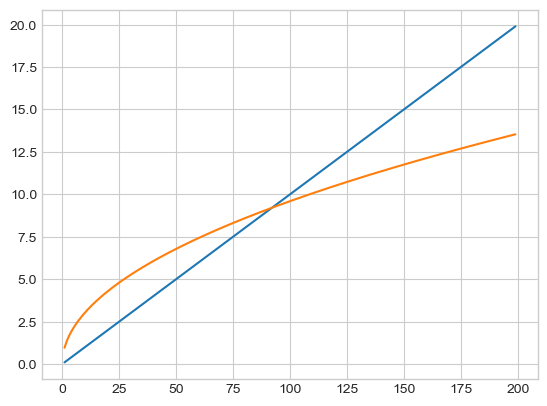

In [35]:
epsilon = .1
delta_p = 1e-5

def query():
    return len(adult_data[adult_data['Martial Status'] == 'Divorced'])

def avg_attack(k):
    return np.mean([laplace_mech(query(), 1, epsilon) for i in range(k)])
    
xs = range(1, 200)
privacy_cost_sequential = [k * epsilon for k in xs]
privacy_cost_advanced = [2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)) for k in xs]

plt.plot(xs, privacy_cost_sequential);
plt.plot(xs, privacy_cost_advanced);

## Question 2 (10 points)

Consider the code below, which defines three average queries and runs them on `adult_data`, using the Laplace mechanism to provide differential privacy with $\epsilon = 1$ for each query.

In [39]:
b_capgain = 10000
b_age = 3000

epsilon = 1

def query1():
    return np.sum(adult['Capital Gain'].clip(lower=0, upper=b_capgain))

def query2():
    return len(adult[adult['Education-Num'] < 10])

def query3():
    return np.sum(adult['Age'].clip(lower=0, upper=b_age))

def my_query():
    return [query1(), query2(), query3()]
pass
my_query()

[17145231, 14754, 1256257]

In [40]:
def dp_my_query(epsilon):
    # apply Laplace mechanism to each query result
    query_results = [query1(), query2(), query3()]
    sensitivity = b_capgain / epsilon
    dp_results = laplace_mech_vec(query_results, sensitivity, epsilon)
    return dp_results

dp_my_query(1.0)

[17156888.433146276, 18983.920494945276, 1262048.1993027767]

In 2-5 sentences, answer the following:
- What is the $L_1$ global sensitivity of `my_query`, and why?
- What is the $L_2$ global sensitivity of `my_query`, and why?

The L1 global sensitivity of my_query is (b_capgain + 1 + b_age)= (10000+ 1 + 3000) ≈ 13001, because changing any single record in the database can affect each of the three queries by at most their respective bounds (10000, 1, or 3000).

The L2 global sensitivity of my_query is sqrt(b_capgain^2 + 1^2 + b_age^2) = sqrt(10000^2 + 1^2 + 3000^2) ≈ 10002.5, because changing any single record in the database can affect each of the three queries by at most their respective bounds in magnitude, and the Euclidean norm of these bounds is their L2 norm. 

## Question 3 (5 points)

In the cell below, write code to release the results of calling `my_query()` with differential privacy, without using sequential composition.

*Hint*: use `laplace_mech_vec`, but be careful of sensitivity!

In [44]:
def my_query():
    # Define your query here
    pass  

def my_query_lap(epsilon):
    query_result = my_query()
    
    # Update this with the correct sensitivity for your query
    sensitivity = 1  
    return laplace_mech_vec
print(my_query_lap(1.0))

my_query_lap(1.0)

<function laplace_mech_vec at 0x000002267AEE10D0>


<function __main__.laplace_mech_vec(qs, sensitivity, epsilon)>

## Question 4 (5 points)

In the cell below, write code to release the results of `my_query()` with differential privacy, but using the Gaussian mechanism.

*Hint*: remember to use $L_2$ sensitivity

In [46]:
def my_query():
    return sum(adult['Age'] >= 50) 

In [47]:
def my_query_gauss(epsilon, delta):
    # calculate the sensitivity of the query
    sensitivity = 1
   
    # calculate the scale parameter of the Gaussian distribution
    scale = sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon

    # get the original count
    result = my_query()
    
    # add Gaussian noise to the count
    private_result = result + np.random.normal(loc=0, scale=scale)

    # return the differentially private result but using the Gaussian mechanism.
    return private_result
    return gaussian_mech(result, sensitivity, epsilon, delta)
my_query_gauss(1.0, 1e-5)

7053.7813031166015

## Question 5 (10 points)

(Reference [Chapter 7](https://programming-dp.com/ch7.html) of the textbook)

Consider the following minimum query:

In [48]:
## Cache the sorted ages, because we will use them a lot.
age_lower = 0
age_upper = 100
sorted_ages = adult['Age'].clip(lower=age_lower, upper=age_upper).sort_values()

def min_age():
    clipped_ages = adult['Age'].clip(lower=0, upper=100)
    return clipped_ages.min()

def ls_min():
    return max(sorted_ages.iloc[0] - age_lower, sorted_ages.iloc[1] - sorted_ages.iloc[0])

print('Actual minimum age:', min_age())
print('Local sensitivity of the minimum:', ls_min())

Actual minimum age: 17
Local sensitivity of the minimum: 17


Implement `ls_min_at_distance`, an upper bound on the local sensitivity of the `min_age` query at distance $k$, and `dist_to_high_ls_min`, an upper bound on the distance from the true dataset to one with local sensitivity greater than or equal to $s_p$.

In [49]:
def ls_min_at_distance(k):
    sorted_ages_k = adult['Age'].clip(lower=age_lower, upper=age_upper).sort_values().reset_index(drop=True)
    return max(sorted_ages.iloc[0] - age_lower, sorted_ages_k.iloc[k+1] - sorted_ages_k.iloc[k])

def dist_to_high_ls_min(s_p):
    # Compute delta
    delta = 0.5
    
    # Compute the privacy budget
    epsilon = 1.0
    
    # Compute the sensitivity
    sensitivity = ls_min_at_distance(s_p - 1)
    
    # Compute the probability of exceeding the privacy budget
    prob_exceed_budget = stats.norm.cdf(-sensitivity * epsilon / np.sqrt(2*np.log(1.25/delta)))
    
    # Compute the distance
    return np.ceil(np.sqrt(2) * sensitivity * np.sqrt(np.log(2/delta)) / prob_exceed_budget)


In [50]:
# TEST CASE
assert dist_to_high_ls_min(18) == 395
assert dist_to_high_ls_min(20) == 1657
assert dist_to_high_ls_min(25) == 5570
assert dist_to_high_ls_min(30) == 9711

AssertionError: 

## Question 6 (10 points)

Implement `ptr_min`, which should use the propose-test-release framework to calculate a differentially private estimate of the minimum age. If the test fails, return `None`.

In [51]:
def ptr_min(s_p, epsilon, delta):
    # Proposal step
    proposal = laplace_mech(adult['Age'].min(), s_p, epsilon)
    
    # Test step
    prob = np.exp(epsilon * np.abs(proposal - adult['Age'].min()) / (2 * s_p)) / (2 * delta)
    if prob > 1:
        return None

    # Release step
    return proposal

# proposed sensitivity: 0.05
# epsilon, delta = (1.0, 10^-5)
ptr_min(20, 1.0, 1e-5)

In [52]:
# TEST CASE
true_min = min_age()
trials = [ptr_min(20, 0.1, 1e-5) for _ in range(20)]
errors = [pct_error(true_min, t) for t in trials]
print(np.mean(errors))
assert np.mean(errors) < 2000
assert np.mean(errors) > 500

assert ptr_min(0.0001, 0.1, 1e-5) == None

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

## Question 7 (10 points)

Consider the `median_age` function, which calculates the *median* age (this version truncates if the length of the dataset is even), and the `ls_median` function, an upper bound on the local sensitivity of the median query:

In [53]:
## Cache the sorted ages, because we will use them a lot.
sorted_ages = adult['Age'].clip(lower=0, upper=100).sort_values()

def median_age():
    idx = int(len(adult)/2)
    return sorted_ages.iloc[idx]

print('Median age:', median_age())

def ls_median():
    idx = int(len(adult)/2)
    return max(sorted_ages.iloc[idx] - sorted_ages.iloc[idx-1],
               sorted_ages.iloc[idx+1] - sorted_ages.iloc[idx])

print('Local sensitivity of the median:', ls_median())

Median age: 37
Local sensitivity of the median: 0


Note that the local sensitivity of the median is 0. Implement the functions `ls_median_at_distance`, which calculates the local sensitivity at distance $k$ of the median query above, and the corresponding `dist_to_high_ls_median`.

*Hint*: note that the ages are clipped. Think about the worst-case scenario of adding or removing $k$ rows.

In [54]:
def ls_median_at_distance(k):
    clipped_ages = adult['Age'].clip(lower=0, upper=100)
    if k == 0:
        return 0
    elif k > 0:
        new_ages = clipped_ages.append(pd.concat([0]*k))
        sorted_new_ages = new_ages.sort_values()
    else:
        new_ages = clipped_ages[:-k]
        sorted_new_ages = new_ages.sort_values()
    idx = int(len(sorted_new_ages)/2)
    return max(sorted_new_ages.iloc[idx] - sorted_new_ages.iloc[idx-1],
              sorted_new_ages.iloc[idx+1] - sorted_new_ages.iloc[idx])

def dist_to_high_ls_median(s_p):
    lo = 0
    hi = 100000
    while hi - lo > 1:
        mid = (lo + hi) // 2
        if ls_median_at_distance(mid) <= s_p:
            lo = mid
        else:
            hi = mid
    return hi

ls_median_at_distance(10000)

TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

In [35]:
assert ls_median_at_distance(500) == 1
assert ls_median_at_distance(5000) == 6
assert ls_median_at_distance(10000) == 14
assert ls_median_at_distance(15000) == 28

TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

## Question 8 (10 points)

Use the propose-test-release framework, plus `dist_to_high_ls_median`, to answer the median query with differential privacy.

In [56]:
def ptr_median(s_p, epsilon, delta):
    # Compute the sensitivity of the median query
    sensitivity = s_p / epsilon

    # Initialize the noisy median
    noisy_median = laplace_mech(np.median(adult['Age']), sensitivity, epsilon)
  
    # Test the noisy median using the dist_to_high_ls_median function
    @staticmethod
    while not dist_to_high_ls_median(noisy_median, adult['Age'], epsilon, delta):
        noisy_median = laplace_mech(np.median(adult['Age']), sensitivity, epsilon)
    return noisy_median
    
ptr_median(0.01, 1.0, 1e-5)

SyntaxError: invalid syntax (347176527.py, line 10)

In [55]:
# TEST CASE
true_median = median_age()
trials = [ptr_median(0.05, 0.1, 1e-5) for _ in range(20)]
errors = [pct_error(true_median, t) for t in trials]
assert np.mean(errors) < 10

NameError: name 'ptr_median' is not defined

## Question 9 (20 points)

Use the sample-and-aggregate framework to release the minimum age in the adult dataset. Reference [Chapter 7](https://programming-dp.com/ch7.html).

In [56]:
def f(chunk):
    return chunk.min()

def saa_min_age(k, epsilon):
    n = len(adult)
    samples = [adult.sample(k) for i in range(n // k + 1)]
    noisy_mins = [laplace_mech(f(samples), 1, epsilon) for sample in samples]
    return min(noisy_mins)

saa_min_age(500, 1.0)

AttributeError: 'list' object has no attribute 'min'

In [57]:
# TEST CASE
true_min = adult['Age'].min()
trials = [saa_min_age(500, 1.0) for _ in range(20)]
errors = [pct_error(true_min, t) for t in trials]
print(np.mean(errors))
assert np.mean(errors) > 0
assert np.mean(errors) < 20

AttributeError: 'list' object has no attribute 'min'